# Packages

In [1]:
import numpy as np
import sympy as sp
from sympy import *
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import gaussian_kde
import seaborn as sns
from scipy.optimize import curve_fit
import pymanopt
from pymanopt.manifolds import Sphere
from pymanopt import Problem
from pymanopt.optimizers import ConjugateGradient
import autograd.numpy as np
import tensorflow as tf

# Secular function

In [2]:
mu=0
sigma=1
M=12
N=10

Generated A
Generated b
Completed Eigen Value decomposition


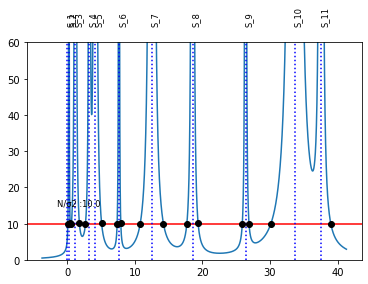

In [3]:
# Generate random matrices A and b from a Gaussian distribution
# A
for i in range(1000):
    A = np.matrix(mu+1*np.random.standard_normal(size=(M,N))).reshape((M,N))
    #W_a
    W=A@A.T
    is_positive_definite = np.all(np.isreal(np.linalg.eigvals(W)))and np.all(np.linalg.eigvals(W) > 0)
    if is_positive_definite :
        print ('Generated A')
        break

# e and b 
e = np.random.standard_normal(size=M)
b=np.matrix(mu+sigma*e).reshape((M,1))
e = np.matrix(e).reshape((M,1))
print('Generated b')

# Eigen values of W_a =A A^T
D, U = np.linalg.eig(W)
S=D
sorted_indices = np.argsort(S)
S = S[sorted_indices]
U = U[:, sorted_indices]
print('Completed Eigen Value decomposition')
#Secular function
#LHS
lbda=np.linspace(S[0]-0.1*np.abs(S[M-1]-S[0]), S[M-1]+0.1*np.abs(S[M-1]-S[0]), num=20000)
Lhs_series=[]
for j in range(len(lbda)):
    lbda_j=lbda[j]
    Lhs=0
    for i in range(len(S)-(M-N)):#-(M-N)

        i=i+(M-N)###################################################+(M-N)
        numerator=e.T@ U[i].T
        numerator=S[i]*np.square(numerator[0,0])
        denominator=np.square(lbda_j-S[i])
        Lhs=Lhs+(numerator)/(denominator)
    Lhs_series.append(Lhs)

#RHS
Rhs=N/np.square(sigma)
#line crossings
idx = np.argwhere(np.diff(np.sign(Lhs_series - Rhs))).flatten()
#visualize secular function
plt.rcParams["figure.figsize"] = (22,5)
k=Rhs+50
plt.ylim([0, k])
plt.plot(lbda, Lhs_series)
plt.axhline(y = Rhs, color = 'r', linestyle = '-')
plt.text(x = -1.5,y=Rhs+5,s='N/σ2 :'+str(round(Rhs,2)),fontsize="small")

for i in range(len(S)-1):

    plt.axvline(x = S[i+1], color = 'b', ls=':',label = 'S_'+str(i+1))
    plt.text(x = S[i+1]-0.1,y=k+5,s='S_'+str((i+1)),rotation=90,fontsize="small")
for index in idx:
    plt.plot(lbda[index], Lhs_series[index], marker = 'o', markerfacecolor = 'black', markeredgecolor = 'black')



# Reimannian Conjugate Gradient Descent

In [9]:
def RCGD_sphere(mu,sigma,M,N):     
    # Generate random matrix A  from a Gaussian distribution    
    for i in range(1000):
        A = np.matrix(mu+1*np.random.standard_normal(size=(M,N))).reshape((M,N))
        W=A@A.T
        is_positive_definite = np.all(np.isreal(np.linalg.eigvals(W)))and np.all(np.linalg.eigvals(W) > 0)
        if is_positive_definite:            
            """print ('found W')"""
            break
    # Generate random matrices b from a Gaussian distribution    
    e = np.random.standard_normal(size=M)
    b=np.matrix(mu+sigma*e).reshape((M,1))
    e = np.matrix(e).reshape((M,1))
    
    # Define the least squares cost function and its gradient
    # Number of dimensions
    n = N
    # Define the sphere manifold
    sphere = Sphere(n,1)
    manifold=sphere
    @pymanopt.function.numpy(manifold)
    def cost(X):
        residual = np.matmul(A , X) - b
        return np.linalg.norm(residual)**2
    @pymanopt.function.numpy(manifold)
    def cost_gradient(X):
        residual = np.matmul(A , X) - b
        return 2*np.matmul( A.T , residual)
    
    # Create a problem with the sphere manifold and the least squares cost function
    problem = Problem(manifold=sphere, cost=cost, euclidean_gradient=cost_gradient)
    # Create a solver
    solver = ConjugateGradient(verbosity=0)#
    # Solve the optimization problem
    Xopt = solver.run(problem)

    # solution
    X_solution=Xopt.point
    lambda_min=np.average(-(A.T @ b - (A.T @ A) @ X_solution)/X_solution)
    e_min=cost(X_solution)/2

    #Flag for negative Lagrange multiplier
    if lambda_min<0:
        n_lg_counter=1
    else:
        n_lg_counter=0
    return [n_lg_counter ,lambda_min ,e_min]  


 #### Simulation 

In [6]:
#no. of simulation runs
nsim=100
# One or more values of standard deviation
sigma_vector=np.concatenate((np.linspace(0.1, 1.25, num=3),np.linspace(1.26, 3, num=2)))
#Dimensions M and N
N=5
M=6
alpha=M/N
#probability of negative minimum Lagrange multiplier 
neg_lagrange_flag_samples_avg=[]
#vectors of flag indicating the presence of negative lagrange multiplier at each simulation run for all $\sigma$
neg_lagrange_flag_samples=[]
#minimal loss/cost for all simulations runs for all $\sigma$
e_min_samples_global=[]
#minimum Lagrange multiplier for all simulations runs for all $\sigma$
lambda_min_samples_global=[]
for j in range(len(sigma_vector)):
    #
    e_min_samples_local=[]
    lambda_min_samples_local=[]
    ###
    
    neg_lagrange_flag=[]
    #position in sigma vector for progress update
    print("-- "+str(j)+" --")
    for i in range(nsim):
        #position in nsim for progress update
        if (i%10)==0:
            print("........"+str(i)+"........." ) 

        try:
            results=RCGD_sphere(0,sigma_vector[j],M,N)
            ###
            lambda_min_samples_local.append(results[1])
            e_min_samples_local.append(results[2])
            neg_lagrange_flag.append(results[0])
 
        except:
            pass
    #save all results        
    neg_lagrange_flag=np.array(neg_lagrange_flag)
    neg_lagrange_flag_samples.append(neg_lagrange_flag)   
    neg_lagrange_flag_samples_avg.append(np.average(neg_lagrange_flag_samples))    
    lambda_min_samples_local=np.array(lambda_min_samples_local)
    lambda_min_samples_global.append(lambda_min_samples_local)    
    e_min_samples_local=np.array(e_min_samples_local)
    e_min_samples_global.append(e_min_samples_local)


-- 0 --
........0.........
........10.........
........20.........
........30.........
........40.........
........50.........
........60.........
........70.........
........80.........
........90.........
-- 1 --
........0.........
........10.........
........20.........
........30.........
........40.........
........50.........
........60.........
........70.........
........80.........
........90.........
-- 2 --
........0.........
........10.........
........20.........
........30.........
........40.........
........50.........
........60.........
........70.........
........80.........
........90.........
-- 3 --
........0.........
........10.........
........20.........
........30.........
........40.........
........50.........
........60.........
........70.........
........80.........
........90.........
-- 4 --
........0.........
........10.........
........20.........
........30.........
........40.........
........50.........
........60.........
........70.........
.....

# Gradient Descent

In [10]:
# Function to calculate the least square cost
def least_square_cost(X, A, b):
    X=X.reshape([N,1])
    return np.linalg.norm(A@X - b)**2
# Gradient of the least square cost function
def gradient_least_square(X, A, b):
    X=X.reshape([N,1])
    residual = (A@X) - b
    gradient = 2 * A.T @residual
    gradient=gradient.reshape([N,1])
    return gradient
#update    
def gradient_based_local_search(X, A, b, step_size):
    X=X.reshape([N,1])   
    gradient = gradient_least_square(X, A, b)
    gradient=gradient.reshape([N,1])
    neighbor_solution =  X.reshape([N,1]) - step_size * gradient
    neighbor_solution=neighbor_solution.reshape([N,1])
    return neighbor_solution
# Gradient descent
def simple_gradient(mu,sigma,M,N, max_iterations, step_size):
   # Generate random matrix A  from a Gaussian distribution    
    for i in range(1000):
        A = np.matrix(mu+1*np.random.standard_normal(size=(M,N))).reshape((M,N))
        W=A@A.T
        is_positive_definite = np.all(np.isreal(np.linalg.eigvals(W)))and np.all(np.linalg.eigvals(W) > 0)
        if is_positive_definite:            
            """print ('found W')"""
            break
    # Generate random matrices b from a Gaussian distribution    
    e = np.random.standard_normal(size=M)
    b=np.matrix(mu+sigma*e).reshape((M,1))
    e = np.matrix(e).reshape((M,1))
 
    final_cost=0
    final_solution=0
    for i in range (10):
        #initialize x on sphere
        initial_X = np.random.randn(N)
        initial_solution=initial_X/np.linalg.norm(initial_X)

        current_solution = initial_solution

        for iteration in range(max_iterations):
            # Generate neighboring solution using gradient-based local search
            neighbor_solution = gradient_based_local_search(current_solution, A, b, step_size)
            #Retraction onto the sphere
            neighbor_solution=neighbor_solution/np.linalg.norm(neighbor_solution)

            # Evaluate cost functions
            current_cost = least_square_cost(current_solution, A, b)
            neighbor_cost = least_square_cost(neighbor_solution, A, b)

            # Calculate the change in cost
            delta_cost = neighbor_cost - current_cost

            # Accept or reject the neighbor
            if delta_cost < 0 :
                current_solution = neighbor_solution
                current_cost=neighbor_cost

        if i==0:
            final_solution=current_solution
            final_cost=current_cost
        else:
            delta_cost = current_cost - final_cost
           # Accept or reject the neighbor
            if delta_cost < 0 :
                final_solution = current_solution
                final_cost=current_cost
 
        lambda_min=np.average(-(A.T @ b - (A.T @ A) @ final_solution)/final_solution)/N
        emin=least_square_cost(final_solution, A, b)/(2*N)
        #Flag for negative Lagrange multiplier
        if lambda_min<0:
            n_lg_counter=1
        else:
            n_lg_counter=0

    return [n_lg_counter,lambda_min,emin]


#### Simulation

In [11]:
#no. of simulation runs
nsim=100
# One or more values of standard deviation
sigma_vector=np.concatenate((np.linspace(0.1, 1.25, num=3),np.linspace(1.26, 3, num=2)))
#Dimensions M and N
N=5
M=6
alpha=M/N
max_iterations=100
step_size=0.01

#probability of negative minimum Lagrange multiplier 
neg_lagrange_flag_samples_avg=[]
#vectors of flag indicating the presence of negative lagrange multiplier at each simulation run for all $\sigma$
neg_lagrange_flag_samples=[]
#minimal loss/cost for all simulations runs for all $\sigma$
e_min_samples_global=[]
#minimum Lagrange multiplier for all simulations runs for all $\sigma$
lambda_min_samples_global=[]
for j in range(len(sigma_vector)):
    #
    e_min_samples_local=[]
    lambda_min_samples_local=[]
    ###
    
    neg_lagrange_flag=[]
    #position in sigma vector for progress update
    print("-- "+str(j)+" --")
    for i in range(nsim):
        #position in nsim for progress update
        if (i%10)==0:
            print("........"+str(i)+"........." ) 

        try:
            results=simple_gradient(0,sigma_vector[j],M,N, max_iterations, step_size)
            ###
            lambda_min_samples_local.append(results[1])
            e_min_samples_local.append(results[2])
            neg_lagrange_flag.append(results[0])
 
        except:
            pass
    #save all results        
    neg_lagrange_flag=np.array(neg_lagrange_flag)
    neg_lagrange_flag_samples.append(neg_lagrange_flag)   
    neg_lagrange_flag_samples_avg.append(np.average(neg_lagrange_flag_samples))    
    lambda_min_samples_local=np.array(lambda_min_samples_local)
    lambda_min_samples_global.append(lambda_min_samples_local)    
    e_min_samples_local=np.array(e_min_samples_local)
    e_min_samples_global.append(e_min_samples_local)


-- 0 --
........0.........
........10.........
........20.........
........30.........
........40.........
........50.........
........60.........
........70.........
........80.........
........90.........
-- 1 --
........0.........
........10.........
........20.........
........30.........
........40.........
........50.........
........60.........
........70.........
........80.........
........90.........
-- 2 --
........0.........
........10.........
........20.........
........30.........
........40.........
........50.........
........60.........
........70.........
........80.........
........90.........
-- 3 --
........0.........
........10.........
........20.........
........30.........
........40.........
........50.........
........60.........
........70.........
........80.........
........90.........
-- 4 --
........0.........
........10.........
........20.........
........30.........
........40.........
........50.........
........60.........
........70.........
.....

# Metropolis Adjusted Langevin 

In [12]:
#loss
def loss_function(x, A, b):
    return np.linalg.norm(A @ x - b)**2
#gradient    
def gradient(x, A, b):
    return 2*A.T @ (A @ x - b)
#retraction
def project_onto_sphere(x):
    norm_x = np.linalg.norm(x)
    return x / norm_x
#MALA update
def mala_update(x, step_size, temperature, A, b):
    gradient_H = gradient(x, A, b)#(np.identity(N)-x@x.T)*
    xi = np.sqrt(2 * step_size * temperature)*np.random.normal(0, 1, size=len(x))
    proposal = x - step_size * gradient_H+xi.reshape((N,1)) 
    proposed_on_sphere = project_onto_sphere(proposal)
    # Metropolis acceptance probability
    current_H = loss_function(x, A, b)
    proposed_H = loss_function(proposed_on_sphere, A, b)
    acceptance_prob = min(1, np.exp((current_H - proposed_H) / temperature))
    delta_c=(current_H - proposed_H)
    # Accept or reject move
    if delta_c>0 or np.random.rand() < acceptance_prob:
        return proposed_on_sphere
    else:
        return x
def simulated_annealing_MALA( mu,sigma,M,N,step_size_schedule, temperature_schedule, max_iterations):
    
    initial_X = np.random.randn(N)
    x=initial_X/np.linalg.norm(initial_X)
    x=x.reshape([N,1])
   # Generate random matrix A  from a Gaussian distribution    
    for i in range(1000):
        A = np.matrix(mu+1*np.random.standard_normal(size=(M,N))).reshape((M,N))
        W=A@A.T
        is_positive_definite = np.all(np.isreal(np.linalg.eigvals(W)))and np.all(np.linalg.eigvals(W) > 0)
        if is_positive_definite:            
            """print ('found W')"""
            break
    # Generate random matrices b from a Gaussian distribution    
    e = np.random.standard_normal(size=M)
    b=np.matrix(mu+sigma*e).reshape((M,1))
    e = np.matrix(e).reshape((M,1))

    
    final_solution=0
    final_cost=0

    for iteration in range(max_iterations):
        epsilon = step_size_schedule[iteration]
        temperature = temperature_schedule[iteration]
        x = mala_update(x, epsilon, temperature, A, b)
        current_solution=x
        current_cost=loss_function(x,A,b)
        
        if iteration==0:
            final_solution=current_solution
            final_cost=current_cost
        else:
            if current_cost<final_cost:
                final_cost=current_cost
                final_solution=current_solution
            else:
                final_cost=final_cost
                final_solution=final_solution
                
    lambda_min=np.average(-(A.T @ b - (A.T @ A) @ final_solution)/final_solution)/N
    emin=loss_function(final_solution, A, b)/(2*N)
    #Flag for negative Lagrange multiplier
    if lambda_min<0:
        n_lg_counter=1
    else:
        n_lg_counter=0

    return [n_lg_counter,lambda_min,emin]


#### Simulation

In [13]:

#no. of simulation runs
nsim=100
# One or more values of standard deviation
sigma_vector=np.concatenate((np.linspace(0.1, 1.25, num=3),np.linspace(1.26, 3, num=2)))
#Dimensions M and N
N=5
M=6
alpha=M/N
max_iterations1 = 300
step_size_schedule = np.linspace(0.001, 0.00085, max_iterations1)  # Example schedule, adjust as needed
temperature_schedule = np.linspace(1/N, 0.5/N, max_iterations1)  # Example schedule, adjust as needed


#probability of negative minimum Lagrange multiplier 
neg_lagrange_flag_samples_avg=[]
#vectors of flag indicating the presence of negative lagrange multiplier at each simulation run for all $\sigma$
neg_lagrange_flag_samples=[]
#minimal loss/cost for all simulations runs for all $\sigma$
e_min_samples_global=[]
#minimum Lagrange multiplier for all simulations runs for all $\sigma$
lambda_min_samples_global=[]
for j in range(len(sigma_vector)):
    #
    e_min_samples_local=[]
    lambda_min_samples_local=[]
    ###
    
    neg_lagrange_flag=[]
    #position in sigma vector for progress update
    print("-- "+str(j)+" --")
    for i in range(nsim):
        #position in nsim for progress update
        if (i%10)==0:
            print("........"+str(i)+"........." ) 

        try:
            results=simulated_annealing_MALA( 0,sigma_vector[j],M,N,step_size_schedule, temperature_schedule, max_iterations)
            ###
            lambda_min_samples_local.append(results[1])
            e_min_samples_local.append(results[2])
            neg_lagrange_flag.append(results[0])
 
        except:
            pass
    #save all results        
    neg_lagrange_flag=np.array(neg_lagrange_flag)
    neg_lagrange_flag_samples.append(neg_lagrange_flag)   
    neg_lagrange_flag_samples_avg.append(np.average(neg_lagrange_flag_samples))    
    lambda_min_samples_local=np.array(lambda_min_samples_local)
    lambda_min_samples_global.append(lambda_min_samples_local)    
    e_min_samples_local=np.array(e_min_samples_local)
    e_min_samples_global.append(e_min_samples_local)


-- 0 --
........0.........
........10.........
........20.........
........30.........
........40.........
........50.........
........60.........
........70.........
........80.........
........90.........
-- 1 --
........0.........
........10.........
........20.........
........30.........
........40.........
........50.........
........60.........
........70.........
........80.........
........90.........
-- 2 --
........0.........
........10.........
........20.........
........30.........
........40.........
........50.........
........60.........
........70.........
........80.........
........90.........
-- 3 --
........0.........
........10.........
........20.........
........30.........
........40.........
........50.........
........60.........
........70.........
........80.........
........90.........
-- 4 --
........0.........
........10.........
........20.........
........30.........
........40.........
........50.........
........60.........
........70.........
.....

# Neural network

In [10]:
# Define the neural network model
def minimization_model(input_size, x_init):
    model = tf.keras.Sequential()
    custom_init_values = x_init.astype(np.float32)
    #Dense layer with 1 neuron
    model.add(tf.keras.layers.Dense(1, use_bias=False,kernel_initializer=tf.constant_initializer(custom_init_values),kernel_constraint=tf.keras.constraints.unit_norm()))
    return model
# Training loop
def train_minimization_model(model, input_data, target, epochs, learning_rate):
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    learning_rate, decay_steps=epochs, decay_rate=1, staircase=True)

    optimizer = tf.optimizers.Adam(learning_rate=lr_schedule)

    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            prediction = model(input_data)
            loss = loss_function(prediction, target)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
#Loss
def loss_function(prediction, target):
    mse_loss = tf.keras.losses.MeanSquaredError()(prediction, target)
    return mse_loss
# Generate random matrix A  from a Gaussian distribution    
for i in range(1000):
    A = np.matrix(mu+1*np.random.standard_normal(size=(M,N))).reshape((M,N))
    W=A@A.T
    is_positive_definite = np.all(np.isreal(np.linalg.eigvals(W)))and np.all(np.linalg.eigvals(W) > 0)
    if is_positive_definite:            
        """print ('found W')"""
        break
# Generate random matrices b from a Gaussian distribution    
e = np.random.standard_normal(size=M)
b=np.matrix(mu+sigma*e).reshape((M,1))
e = np.matrix(e).reshape((M,1))

#neural network for system of linear equations
def nn_opt(A,b,learning_rate,epochs):     
    A2 = tf.constant(A, dtype=tf.float32)
    b2 = tf.constant(b, dtype=tf.float32)
    x_init=np.random.randn(N)
    x_init=x_init/np.linalg.norm(x_init)
    learning_rate=learning_rate
    # Define the loss function

    # Create and train the model with multiple dense layers
    input_size = A.shape[1]
    model = minimization_model(input_size,x_init )
    train_minimization_model(model, A2, b2,epochs,learning_rate)
    x_result=model.layers[-1].kernel.numpy()
    Xopt_point2=x_result
    A=np.matrix(A)
    b=np.matrix(b)

    lambda_min=np.average(-(A.T @ b - (A.T @ A) @ x_result)/x_result)/N
    e_min=(np.linalg.norm(A@model.layers[-1].kernel.numpy()-b)**2)/(2*N)
    if lambda_min<0:
        n_lg_counter=1
    else:
        n_lg_counter=0

    
    return [n_lg_counter,lambda_min,e_min] 

#### Simulation

In [ ]:

#no. of simulation runs
nsim=100
# One or more values of standard deviation
sigma_vector=np.concatenate((np.linspace(0.1, 1.25, num=3),np.linspace(1.26, 3, num=2)))
#Dimensions M and N
N=5
M=6
alpha=M/N
learning_rate=0.01
epochs=200

#probability of negative minimum Lagrange multiplier 
neg_lagrange_flag_samples_avg=[]
#vectors of flag indicating the presence of negative lagrange multiplier at each simulation run for all $\sigma$
neg_lagrange_flag_samples=[]
#minimal loss/cost for all simulations runs for all $\sigma$
e_min_samples_global=[]
#minimum Lagrange multiplier for all simulations runs for all $\sigma$
lambda_min_samples_global=[]
for j in range(len(sigma_vector)):
    #
    e_min_samples_local=[]
    lambda_min_samples_local=[]
    ###
    
    neg_lagrange_flag=[]
    #position in sigma vector for progress update
    print("-- "+str(j)+" --")
    for i in range(nsim):
        #position in nsim for progress update
        if (i%10)==0:
            print("........"+str(i)+"........." ) 

        try:
            # Generate random matrix A  from a Gaussian distribution    
            for i in range(1000):
                A = np.matrix(mu+1*np.random.standard_normal(size=(M,N))).reshape((M,N))
                W=A@A.T
                is_positive_definite = np.all(np.isreal(np.linalg.eigvals(W)))and np.all(np.linalg.eigvals(W) > 0)
                if is_positive_definite:            
                    """print ('found W')"""
                    break
            # Generate random matrices b from a Gaussian distribution    
            e = np.random.standard_normal(size=M)
            b=np.matrix(mu+sigma*e).reshape((M,1))
            e = np.matrix(e).reshape((M,1))

            results=nn_opt(A,b,learning_rate,epochs)
            ###
            lambda_min_samples_local.append(results[1])
            e_min_samples_local.append(results[2])
            neg_lagrange_flag.append(results[0])
 
        except:
            pass
    #save all results        
    neg_lagrange_flag=np.array(neg_lagrange_flag)
    neg_lagrange_flag_samples.append(neg_lagrange_flag)   
    neg_lagrange_flag_samples_avg.append(np.average(neg_lagrange_flag_samples))    
    lambda_min_samples_local=np.array(lambda_min_samples_local)
    lambda_min_samples_global.append(lambda_min_samples_local)    
    e_min_samples_local=np.array(e_min_samples_local)
    e_min_samples_global.append(e_min_samples_local)


-- 0 --
........0.........
........10.........
........20.........
........30.........
........40.........
........50.........
........60.........
........70.........


# Negative Lagrange multiplier counting, pick any algorithm and use neg_lagrange_flag_samples_avg from that algorithm

In [ ]:
sigma_var=sigma_vector
neg_l_count_avg=neg_lagrange_flag_samples_avg

In [ ]:

plt.rcParams["figure.figsize"] = (12,10)
#sigma_var0=sigma_var
import numpy as np
from scipy.special import gamma, factorial
import scipy.special as sc
import math
sigma_var_th=np.linspace(0.1, 3, num=200)
#M=15
#N=12
MN=M-N
MNp=MN+1
MNn=MN-1
neg_l_count_avg_org=[]
for j in range(len(sigma_var_th)):
    P= 2*np.sqrt(math.pi)*factorial(M-1)*factorial(N-1)
    sigmv=sigma_var_th[j]
    Q=np.power(sigmv,MNn)
    R=P*Q
    Q=gamma(N/2)*gamma(M/2)*(np.power(1+np.sqrt(1+np.power(sigma_var_th[j],2)),M-N))*np.power(2*np.sqrt(1+np.power(sigma_var_th[j],2)),N-1)
    A=R/Q

    B=0
    for k in range(N):
        B=B+( np.power(  np.power(sigma_var_th[j],2)/(1+np.sqrt(1+np.power(sigma_var_th[j],2)) ) ,k+1 ) * sc.hyp2f1(M-N+k+1, (M-N+1)/2, ((M-N+1)/2)+k+1 , (1-np.sqrt(1+np.power(sigma_var_th[j],2) ))/(1+np.sqrt(1+np.power(sigma_var_th[j],2))) ) )/(gamma(N-k)*gamma(((M-N+1)/2)+k+1))
    neg_l_count_avg_org.append(A*B)
plt.plot(sigma_var,neg_l_count_avg,label="simulation")
plt.plot(sigma_var,neg_l_count_avg,'o')
plt.plot(sigma_var_th,neg_l_count_avg_org,label=r'$<\lambda_{\sigma}^{-}>$')    

# Function add a legend   
plt.legend(loc='lower right') 
plt.xlabel(r'$\sigma$')
plt.ylabel(r'$<\lambda_{\sigma}^{-}>$')

plt.title("M= "+str(M)+","+"N= "+str(N)+", n_samples= "+str(nsim));  
# function to show the plot 
plt.show() 

# Analysis of Results for demonstration: from one instance of results from the past

In [20]:
# gets normalized asymptotic mean minimal error for given alpha and sigma
def emin_star_lde (alpha,sigma):
    emin_star_lde_value=((np.sqrt(alpha*(1+sigma**2))-1)**2)/2
    return emin_star_lde_value

In [33]:
#N=50,M=75,alpha=1.5,sigma=0.5
M=75
N=50
alpha=1.5
sigma_var[0]=0.5
nsim=10000
#saved results: e_min_samples_global[0] after running code for one sigma(sigma_vector=[0.5]) for each of the algorithms
e_min_st_pyman=np.load('pyman_e_min_N50_10000sim_sg0_5.npy')
e_min_st_nn=np.load('nn_e_min_N50_10000sim_sg0_5.npy')
e_min_st_sa=np.load('mala_e_min_N50_10000sim_sg0_5.npy')
e_min_st_gd=np.load('gd_e_min_N50_10000sim_sg0_5.npy')
#saved results: lambda_min_samples_global[0] after running code for one sigma(sigma_vector=[0.5]) for each of the algorithms
lambda_min_st_pyman=np.load('pyman_lambda_min_N50_10000sim_sg0_5.npy')
lambda_min_st_nn=np.load('nn_lambda_min_N50_10000sim_sg0_5.npy')
lambda_min_st_sa=np.load('mala_lambda_min_N50_10000sim_sg0_5.npy')
lambda_min_st_gd=np.load('gd_lambda_min_N50_10000sim_sg0_5.npy')


#### Visualization of e_min

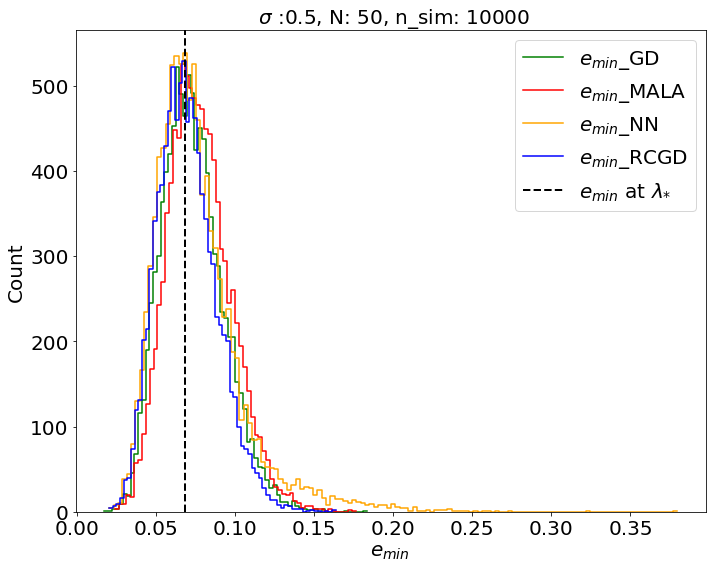

In [34]:
plt.rcParams["figure.figsize"] = (10,8)

import seaborn as sns
# Create a 5x2 grid of subplots
sns.histplot(e_min_st_gd,fill=False, color='green',label=r'$e_{min}$_GD',alpha=0.5,element='step')#, ,norm_hist=False,kde=False,fill=True        
sns.histplot(e_min_st_sa,fill=False, color='red',label=r'$e_{min}$_MALA',alpha=0.4,element='step')#, ,norm_hist=False,kde=False,fill=True        
sns.histplot(e_min_st_nn,fill=False, color='orange',label=r'$e_{min}$_NN',alpha=0.3,element='step')#, ,norm_hist=False,kde=False,fill=True
sns.histplot(e_min_st_pyman,fill=False, color='b',label=r'$e_{min}$_RCGD',alpha=0.2,element='step')#, ,norm_hist=False,kde=False,fill=True        

#ax.set_xlim(0, ax.get_xlim()[1])

#"""
#sns.histplot(e_min_stats[i]/(N),stat='probability',kde=True,element='step', color='skyblue', fill=True)
#plt.get_lines()[0].set_color('black')
#"""

vertical_line_value=emin_star_lde(alpha,sigma_var[0])#*50
plt.axvline(x=vertical_line_value, color='black', linestyle='dashed', linewidth=2,label=r'$e_{min}$ at $\lambda_{*}$')
# Label the line
#ax.text(vertical_line_value + 0.1, plt.ylim()[1] * 0.9, 'e_min_lde', rotation=90, color='red')

plt.title(r' $\sigma$ :'+str(round(sigma_var[0],2))+", N: "+str(N)+", n_sim: "+str(nsim),fontsize=20)
plt.xlabel(r'$e_{min}$ ',fontsize=20)        
plt.ylabel('Count',fontsize=20)        
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Adjust layout and add a title
plt.tight_layout()
#plt.suptitle('E_min', fontsize=16,y=0.995)
plt.legend(fontsize=20)
# Show the plot
plt.show()

# Large Deviation rate of minimal cost

In [35]:
# Analytical
def lde_for_givene1(errors,sigmavs):
    er_range=[]
    for i in range(10):
        er_range.append(errors-0.005*(10-i)*1)
    er_range.append(errors)
    for i in range(10):
        er_range.append(errors+0.005*(i)*1)
        
    """er_range.append(np.linspace(errors*0.05, errors, 10))
    er_range.append(np.linspace(errors, 1.05*errors, 10))
    er_range=np.unique(er_range)"""
    #print(er_range)
    
    lderates=[]
    from sympy import symbols, solve
    #print(er_range)
    for j in range(len(er_range)):
        errorsl=er_range[j]
        #lderate=

        # Define the variable
        x = symbols('x')
        # Define the cubic equation
        #errors=0.5*(np.sqrt(1.5*(1+sigmavs**2))-1)**2
        alpha=M/N
        equation = (sigmavs**2)* (x**3) + (sigmavs**2-1)*x**2 + ( ( (alpha-1)*(1+sigmavs**2)/(2*errorsl) )-1)*x - (1+sigmavs**2)/(2*errorsl)

        # Find the solutions
        solutions = solve(equation, x,real=True)
        solutions = [sol.evalf() for sol in solutions if im(sol) == 0]
        lderate=[]
        for i in range(len(solutions)):
            lderate.append(errorsl*solutions[i]- 1/(2*solutions[i]) - ((alpha-1)/2)*np.log(2*errorsl)+(alpha/2)*np.log(alpha*(1+sigmavs**2))+np.log(float(solutions[i]))-alpha*np.log(1+float(solutions[i])))
        #solutions[np.array(np.where(lderate==np.min(lderate))).tolist()[0][0]]
        lderates.append(float(np.min(lderate) ))# [x for x in lderate if x >= 0]       
    return lderates   
#Numerical
def lde_simdata(V_values):
    kde = gaussian_kde(V_values)
    probabilities = kde(V_values)
    LER_num=(-np.log(probabilities)/N)
    min_LER=np.min(LER_num)
    if min_LER<0:
        min_LER=np.min(lde_rates1)-min_LER
    else:
        min_LER=np.min(lde_rates1)-min_LER
    LER_num=LER_num+min_LER
    
    return LER_num
#gets analytically derived normalized asymptotic mean minimal cost 
def emin_star_lde (alpha,sigma):
    emin_star_lde_value=((np.sqrt(alpha*(1+sigma**2))-1)**2)/2
    return emin_star_lde_value

#### Visualization

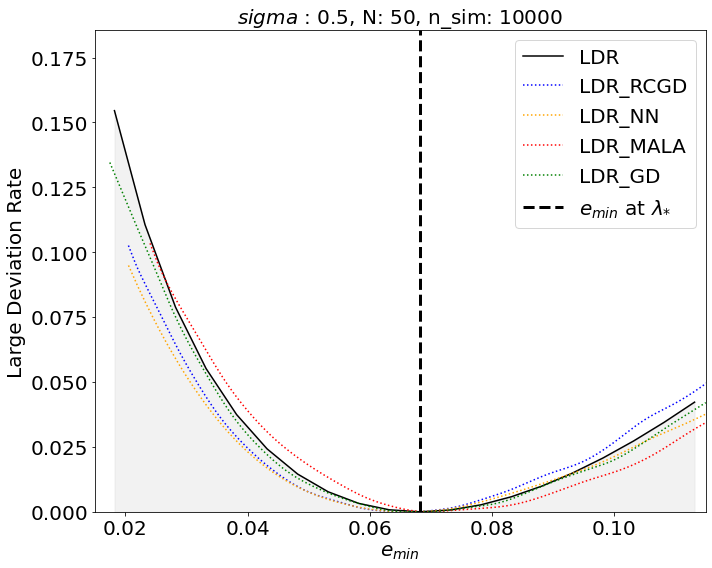

In [36]:
er_range2=e_min_st_pyman
er_range2=np.sort(er_range2)
er_range3=e_min_st_nn
er_range3=np.sort(er_range3)
er_range4=e_min_st_sa
er_range4=np.sort(er_range4)
er_range5=e_min_st_gd
er_range5=np.sort(er_range5)

i=0
#N=50
sigmavs=sigma_var[0]

############################################# old_lde_rates from formula
alpha=M/N
errors=0.5*(np.sqrt(alpha*(1+sigmavs**2))-1)**2

lde_rates1=lde_for_givene1(errors,sigmavs)


############################################ lde from data
#lde_rates2=lde_for_givene2(er_range2,sigmavs)
lde_rates3=lde_simdata(er_range2)
lde_rates4=lde_simdata(er_range3)
lde_rates5=lde_simdata(er_range4)
lde_rates6=lde_simdata(er_range5)

er_range=[]
for j in range(10):
    er_range.append(errors-0.005*(10-j)*1)
er_range.append(errors)
for j in range(10):
    er_range.append(errors+0.005*(j)*1)
plt.rcParams["figure.figsize"] = (10,8)

# Create a 5x2 grid of subplots

plt.plot(er_range,lde_rates1,color='black',label='LDR')
plt.fill_between(er_range,lde_rates1, color='grey', alpha=0.1)
plt.plot(er_range2,lde_rates3,linestyle='dotted',color='b',label='LDR_RCGD')
plt.plot(er_range3,lde_rates4,linestyle='dotted',color='orange',label='LDR_NN')
plt.plot(er_range4,lde_rates5,linestyle='dotted',color='red',label='LDR_MALA')
plt.plot(er_range5,lde_rates6,linestyle='dotted',color='green',label='LDR_GD')

from scipy.stats import probplot
import pandas as pd

plt.xlim(0.015,0.115)
plt.ylim(0,1.2*np.max(lde_rates1))


vertical_line_value=emin_star_lde(alpha,sigma_var[i])#*50
plt.axvline(x=vertical_line_value, color='black', linestyle='dashed', linewidth=3,label=r'$e_{min}$ at $\lambda_{*}$')
# Label the line



plt.title(r'$sigma$ : '+str(round(sigma_var[i],2))+", N: "+str(N)+", n_sim: "+str(nsim),fontsize=20)
        
plt.xlabel(r'$e_{min}$',fontsize=20)
plt.ylabel(r'Large Deviation Rate',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Adjust layout and add a title
plt.tight_layout()
#plt.suptitle('Large deviation rate', fontsize=16,y=0.995)

plt.legend(fontsize=20)
# Show the plot

plt.show()